## Loading the dataset

In [1]:
import pandas as pd
df = pd.read_csv("./year_week.csv")
df.head()

,production,p_per_m2,p_max,panel_area,facade_area,total_panel_area,exploitation_ratio,air_temp_mean,air_temp_max,clearsky_ghi_mean,...,relative_humidity_max,surface_pressure_mean,surface_pressure_min,surface_pressure_max,wind_direction_100m_mean,wind_direction_100m_min,wind_direction_100m_max,wind_speed_100m_mean,wind_speed_100m_min,wind_speed_100m_max
0,5.200000,143.0,210.0,1.72,218.0,94.6,0.434,2.505230,4.200000,60.951418,...,94.220000,1034.960009,1033.440000,1037.220000,270.313918,194.000000,328.400000,4.257234,1.920000,5.860000
1,1.400000,143.0,210.0,1.72,218.0,94.6,0.434,2.479167,4.000000,60.812500,...,95.900000,1034.843750,1031.700000,1038.100000,259.770833,227.000000,339.000000,5.036170,2.000000,6.200000
2,2.742857,143.0,210.0,1.72,218.0,94.6,0.434,2.639881,3.571429,64.693452,...,92.528571,1025.654167,1022.557143,1028.500000,246.068452,156.428571,311.714286,5.367262,3.328571,7.528571
3,1.200000,143.0,210.0,1.72,218.0,94.6,0.434,2.895833,4.000000,64.312500,...,93.500000,1024.008333,1020.000000,1027.300000,251.979167,213.000000,300.000000,4.456250,2.500000,7.700000
4,14.614286,143.0,210.0,1.72,218.0,94.6,0.434,3.446429,5.857143,71.940476,...,91.314286,1015.603869,1011.585714,1020.142857,210.104167,169.714286,266.285714,5.892857,3.800000,7.757143


## Preoaring the (x,y) pairs

### Scaling the data

In [2]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df.values)

### Creating windows

In [3]:
production_column = 'production'

def get_target_column_index(df, target_column):
    for i, column in enumerate(df.columns):
        if column == target_column:
            return i

    return -1

In [4]:
import numpy as np

def get_windows(data, window_size=10):
    x = []
    y = []

    for i in range(window_size, len(data)):
        x.append(data[i-window_size:i])
        y.append(data[i][get_target_column_index(df, production_column)])

    return np.array(x), np.array(y)

In [5]:
window_size = 2*12  # 2*1h window
x, y = get_windows(data_scaled, window_size=window_size)

x.shape, y.shape

((3150, 24, 34), (3150,))

### Splitting the data

In [6]:
train_split_index = int(0.8 * len(df))
test_split_index = int(0.9 * len(df))

x_train, y_train = x[:train_split_index], y[:train_split_index]
x_test, y_test = x[train_split_index:test_split_index], y[train_split_index:test_split_index]
x_val, y_val = x[test_split_index:], y[test_split_index:]

x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((2539, 24, 34), (2539,), (317, 24, 34), (317,), (294, 24, 34), (294,))

### Plotting the splits

In [7]:
import matplotlib.pyplot as plt


def plot_time_series(timesteps, values, label, format='-^', start=0, end=None):
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("date")
    plt.ylabel("production")

    plt.legend(fontsize=14)
    plt.grid(True)

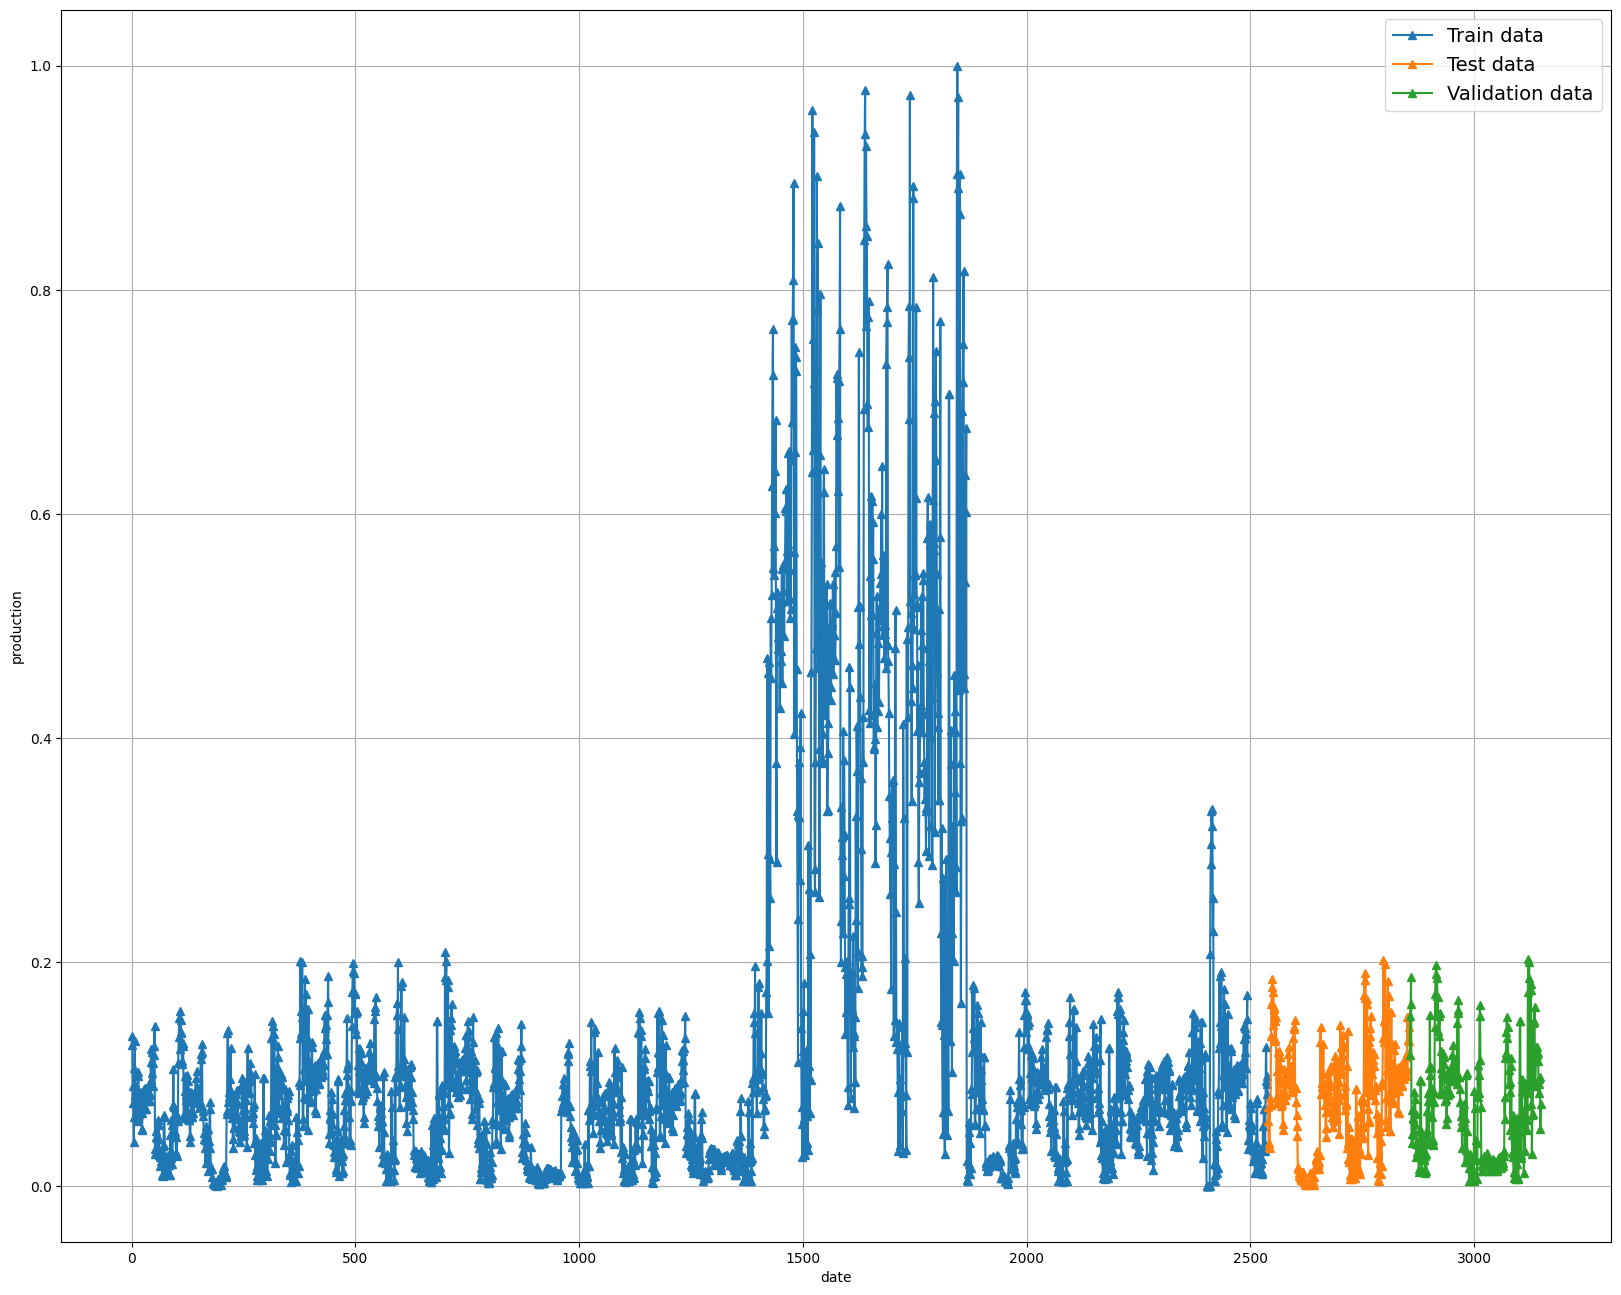

In [8]:
plt.figure(figsize=(20, 16))

timesteps = range(len(x_train))
plot_time_series(timesteps=timesteps, values=y_train, label="Train data")

timesteps = range(len(x_train), len(x_train) + len(x_test))
plot_time_series(timesteps=timesteps, values=y_test, label="Test data")

timesteps = range(len(x_train) + len(x_test),
                  len(x_train) + len(x_test) + len(x_val))
plot_time_series(timesteps=timesteps, values=y_val, label="Validation data")

### Preparing the performances metrics

In [9]:
import tensorflow as tf
from sklearn.metrics import r2_score

In [10]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return {
        'mse': mse,
        'r2': r2,
        'mae': mae,
        'mape': mape,
    }

In [11]:
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae_metric = tf.keras.metrics.MeanAbsoluteError()
    mse_metric = tf.keras.metrics.MeanSquaredError()

    mae_metric.update_state(y_true, y_pred)
    mse_metric.update_state(y_true, y_pred)

    mae = mae_metric.result().numpy()
    mse = mse_metric.result().numpy()
    r2 = r2_score(y_true.numpy(), y_pred.numpy())  # Assure-toi que y_true et y_pred sont des numpy arrays

    return {
        "mae": mae,
        "mse": mse,
        "r2": r2
    }

## Modeling

In [12]:
import os
import tensorflow as tf

from keras.layers import Dense, Dropout, LSTM, Flatten, ConvLSTM1D, MaxPool1D, GlobalMaxPool1D, Conv1D, Conv2D
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

### Plotting the loss

In [13]:
def plot_loss(history):
    plt.figure(figsize=(20, 8))

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

### Creating callbacks

In [14]:
stop_early = EarlyStopping(monitor='val_loss', patience=5)


def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                              verbose=0,
                                              save_best_only=True)

### Utils function

In [15]:
def make_preds(model, input_data):
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

## ConvLSTM

#### Preparing the model

In [16]:
x_train_conv_lstm = np.expand_dims(x_train, axis=2)
x_val_conv_lstm = np.expand_dims(x_val, axis=2)
x_test_conv_lstm = np.expand_dims(x_test, axis=2)

print(f"{x_train.shape} -> {x_train_conv_lstm.shape}")

(2539, 24, 34) -> (2539, 24, 1, 34)


In [17]:
tf.random.set_seed(42)

input_shape = (x_train_conv_lstm.shape[1:])
conv_lstm_model = tf.keras.Sequential([
    ConvLSTM1D(filters=64, kernel_size=(1,), activation='tanh',
               return_sequences=True, input_shape=input_shape),
    ConvLSTM1D(filters=64, kernel_size=(1,),
               activation='tanh', return_sequences=False),
    Flatten(),
    Dense(units=64, activation='relu'),
    Dense(1, activation="linear")
], name="model_conv_lstm.keras")

conv_lstm_model.compile(loss="mae",
                        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

conv_lstm_model.summary()


Model: "model_conv_lstm.keras"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm1d (ConvLSTM1D)    (None, 24, 1, 64)         25344     
                                                                 
 conv_lstm1d_1 (ConvLSTM1D)  (None, 1, 64)             33024     
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 62593 (244.50 KB)
Trainable params: 62593 (244.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Training the model convlstm

In [18]:
import os
import time
import logging
from codecarbon import EmissionsTracker


os.makedirs('emissions', exist_ok=True)

tracker_conv_lstm = EmissionsTracker(
    project_name="PEWH",
    co2_signal_api_token="9RkoBO6iipmoq",
    log_level=logging.INFO,
    output_file="emissions_conv_lstm.csv",
    output_dir='./emissions/',
    save_to_file=True,
    measure_power_secs=10
)

[codecarbon INFO @ 01:31:47] [setup] RAM Tracking...
[codecarbon INFO @ 01:31:47] [setup] CPU Tracking...
[codecarbon WARNING @ 01:31:47] No CPU tracking mode found. Falling back on CPU constant mode. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon WARNING @ 01:31:48] We saw that you have a 12th Gen Intel(R) Core(TM) i7-12700H but we don't know it. Please contact us.
[codecarbon INFO @ 01:31:48] CPU Model on constant consumption mode: 12th Gen Intel(R) Core(TM) i7-12700H
[codecarbon INFO @ 01:31:48] [setup] GPU Tracking...
[codecarbon INFO @ 01:31:50] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 01:31:50] >>> Tracker's metadata:
[codecarbon INFO @ 01:31:50]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 01:31:50]   Python version: 3.11.3
[codecarbon INFO @ 01:31:50]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 01:31:50]   Available RAM : 31.711 GB
[codecarbon INFO @ 01:31:50]   CPU count: 20
[codecarbon INFO @ 01:31:50]   CPU

In [19]:
def start_training_conv_lstm():
    start_time = time.time()
    conv_lstm_history = conv_lstm_model.fit(x=x_train_conv_lstm,
                                            y=y_train,
                                            epochs=300,
                                            verbose=1,
                                            batch_size=512,
                                            validation_data=(
                                                x_val_conv_lstm, y_val),
                                            callbacks=[create_model_checkpoint(model_name=conv_lstm_model.name)])
    training_duration = time.time() - start_time

    return conv_lstm_history, training_duration

In [20]:
tracker_conv_lstm.start()
try:
    history_conv_lstm, training_duration_conv_lstm = start_training_conv_lstm()
finally:
    tracker_conv_lstm.stop()

Epoch 1/300



[codecarbon INFO @ 01:32:00] Energy consumed for RAM : 0.000033 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 01:32:00] Energy consumed for all CPUs : 0.000118 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:32:01] Energy consumed for all GPUs : 0.000003 kWh. Total GPU Power : 1.118048631356685 W
[codecarbon INFO @ 01:32:01] 0.000155 kWh of electricity used since the beginning.


5/5 [==============================] - 15s 627ms/step - loss: 0.1165 - val_loss: 0.0465
Epoch 2/300
5/5 [==============================] - 1s 230ms/step - loss: 0.0753 - val_loss: 0.0422
Epoch 3/300
5/5 [==============================] - 1s 206ms/step - loss: 0.0584 - val_loss: 0.0363
Epoch 4/300
5/5 [==============================] - 1s 192ms/step - loss: 0.0538 - val_loss: 0.0374
Epoch 5/300
5/5 [==============================] - 1s 202ms/step - loss: 0.0528 - val_loss: 0.0341
Epoch 6/300
5/5 [==============================] - ETA: 0s - loss: 0.0513

[codecarbon INFO @ 01:32:10] Energy consumed for RAM : 0.000061 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 01:32:10] Energy consumed for all CPUs : 0.000220 kWh. Total CPU Power : 42.5 W


5/5 [==============================] - 1s 208ms/step - loss: 0.0513 - val_loss: 0.0339
Epoch 7/300
5/5 [==============================] - 1s 168ms/step - loss: 0.0496 - val_loss: 0.0366
Epoch 8/300
3/5 [=================>............] - ETA: 0s - loss: 0.0472

[codecarbon INFO @ 01:32:11] Energy consumed for all GPUs : 0.000013 kWh. Total GPU Power : 4.1574382952704285 W
[codecarbon INFO @ 01:32:11] 0.000295 kWh of electricity used since the beginning.


5/5 [==============================] - 1s 157ms/step - loss: 0.0486 - val_loss: 0.0347
Epoch 9/300
5/5 [==============================] - 1s 171ms/step - loss: 0.0480 - val_loss: 0.0342
Epoch 10/300
5/5 [==============================] - 1s 162ms/step - loss: 0.0482 - val_loss: 0.0341
Epoch 11/300
5/5 [==============================] - 1s 160ms/step - loss: 0.0473 - val_loss: 0.0373
Epoch 12/300
5/5 [==============================] - 1s 186ms/step - loss: 0.0472 - val_loss: 0.0335
Epoch 13/300
5/5 [==============================] - 1s 161ms/step - loss: 0.0466 - val_loss: 0.0337
Epoch 14/300
5/5 [==============================] - 1s 182ms/step - loss: 0.0459 - val_loss: 0.0337
Epoch 15/300
5/5 [==============================] - 1s 154ms/step - loss: 0.0457 - val_loss: 0.0341
Epoch 16/300
5/5 [==============================] - 1s 200ms/step - loss: 0.0452 - val_loss: 0.0330
Epoch 17/300
5/5 [==============================] - 1s 167ms/step - loss: 0.0447 - val_loss: 0.0334
Epoch 18/300
4

[codecarbon INFO @ 01:32:20] Energy consumed for RAM : 0.000090 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 01:32:20] Energy consumed for all CPUs : 0.000322 kWh. Total CPU Power : 42.5 W


5/5 [==============================] - 1s 183ms/step - loss: 0.0443 - val_loss: 0.0332
Epoch 19/300
5/5 [==============================] - 1s 168ms/step - loss: 0.0437 - val_loss: 0.0329
Epoch 20/300
3/5 [=================>............] - ETA: 0s - loss: 0.0421

[codecarbon INFO @ 01:32:21] Energy consumed for all GPUs : 0.000024 kWh. Total GPU Power : 4.47141762349578 W
[codecarbon INFO @ 01:32:21] 0.000435 kWh of electricity used since the beginning.


5/5 [==============================] - 1s 173ms/step - loss: 0.0441 - val_loss: 0.0319
Epoch 21/300
5/5 [==============================] - 1s 163ms/step - loss: 0.0439 - val_loss: 0.0339
Epoch 22/300
5/5 [==============================] - 1s 163ms/step - loss: 0.0436 - val_loss: 0.0321
Epoch 23/300
5/5 [==============================] - 1s 170ms/step - loss: 0.0444 - val_loss: 0.0325
Epoch 24/300
5/5 [==============================] - 1s 193ms/step - loss: 0.0433 - val_loss: 0.0312
Epoch 25/300
5/5 [==============================] - 1s 190ms/step - loss: 0.0446 - val_loss: 0.0355
Epoch 26/300
5/5 [==============================] - 1s 177ms/step - loss: 0.0453 - val_loss: 0.0334
Epoch 27/300
5/5 [==============================] - 1s 174ms/step - loss: 0.0434 - val_loss: 0.0322
Epoch 28/300
5/5 [==============================] - 1s 180ms/step - loss: 0.0426 - val_loss: 0.0325
Epoch 29/300
5/5 [==============================] - 1s 180ms/step - loss: 0.0426 - val_loss: 0.0341
Epoch 30/300


[codecarbon INFO @ 01:32:30] Energy consumed for RAM : 0.000118 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 01:32:30] Energy consumed for all CPUs : 0.000424 kWh. Total CPU Power : 42.5 W


5/5 [==============================] - 1s 160ms/step - loss: 0.0425 - val_loss: 0.0330
Epoch 31/300
5/5 [==============================] - 1s 157ms/step - loss: 0.0423 - val_loss: 0.0346
Epoch 32/300
1/5 [=====>........................] - ETA: 0s - loss: 0.0424

[codecarbon INFO @ 01:32:31] Energy consumed for all GPUs : 0.000033 kWh. Total GPU Power : 4.037203915018957 W
[codecarbon INFO @ 01:32:31] 0.000575 kWh of electricity used since the beginning.


5/5 [==============================] - 1s 149ms/step - loss: 0.0426 - val_loss: 0.0346
Epoch 33/300
5/5 [==============================] - 1s 162ms/step - loss: 0.0422 - val_loss: 0.0343
Epoch 34/300
5/5 [==============================] - 1s 170ms/step - loss: 0.0432 - val_loss: 0.0330
Epoch 35/300
5/5 [==============================] - 1s 174ms/step - loss: 0.0422 - val_loss: 0.0314
Epoch 36/300
5/5 [==============================] - 1s 194ms/step - loss: 0.0410 - val_loss: 0.0302
Epoch 37/300
5/5 [==============================] - 1s 192ms/step - loss: 0.0408 - val_loss: 0.0302
Epoch 38/300
5/5 [==============================] - 1s 194ms/step - loss: 0.0403 - val_loss: 0.0299
Epoch 39/300
5/5 [==============================] - 1s 196ms/step - loss: 0.0396 - val_loss: 0.0293
Epoch 40/300
5/5 [==============================] - 1s 178ms/step - loss: 0.0397 - val_loss: 0.0296
Epoch 41/300
5/5 [==============================] - 1s 154ms/step - loss: 0.0394 - val_loss: 0.0282
Epoch 42/300


[codecarbon INFO @ 01:32:40] Energy consumed for RAM : 0.000147 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 01:32:40] Energy consumed for all CPUs : 0.000525 kWh. Total CPU Power : 42.5 W


5/5 [==============================] - 1s 157ms/step - loss: 0.0402 - val_loss: 0.0290
Epoch 43/300
5/5 [==============================] - 1s 171ms/step - loss: 0.0400 - val_loss: 0.0279


[codecarbon INFO @ 01:32:41] Energy consumed for all GPUs : 0.000043 kWh. Total GPU Power : 4.079926559989399 W
[codecarbon INFO @ 01:32:41] 0.000715 kWh of electricity used since the beginning.


Epoch 44/300
5/5 [==============================] - 1s 151ms/step - loss: 0.0405 - val_loss: 0.0286
Epoch 45/300
5/5 [==============================] - 1s 190ms/step - loss: 0.0385 - val_loss: 0.0276
Epoch 46/300
5/5 [==============================] - 1s 161ms/step - loss: 0.0389 - val_loss: 0.0279
Epoch 47/300
5/5 [==============================] - 1s 171ms/step - loss: 0.0390 - val_loss: 0.0301
Epoch 48/300
5/5 [==============================] - 1s 177ms/step - loss: 0.0403 - val_loss: 0.0281
Epoch 49/300
5/5 [==============================] - 1s 164ms/step - loss: 0.0384 - val_loss: 0.0294
Epoch 50/300
5/5 [==============================] - 1s 154ms/step - loss: 0.0392 - val_loss: 0.0309
Epoch 51/300
5/5 [==============================] - 1s 183ms/step - loss: 0.0393 - val_loss: 0.0272
Epoch 52/300
5/5 [==============================] - 1s 150ms/step - loss: 0.0382 - val_loss: 0.0284
Epoch 53/300
5/5 [==============================] - 1s 167ms/step - loss: 0.0384 - val_loss: 0.0271


[codecarbon INFO @ 01:32:50] Energy consumed for RAM : 0.000175 kWh. RAM Power : 11.891499996185303 W


4/5 [=======================>......] - ETA: 0s - loss: 0.0393

[codecarbon INFO @ 01:32:50] Energy consumed for all CPUs : 0.000627 kWh. Total CPU Power : 42.5 W


5/5 [==============================] - 1s 159ms/step - loss: 0.0385 - val_loss: 0.0275
Epoch 55/300
5/5 [==============================] - 1s 158ms/step - loss: 0.0372 - val_loss: 0.0265
Epoch 56/300
2/5 [===========>..................] - ETA: 0s - loss: 0.0384

[codecarbon INFO @ 01:32:52] Energy consumed for all GPUs : 0.000053 kWh. Total GPU Power : 4.085777771212301 W
[codecarbon INFO @ 01:32:52] 0.000855 kWh of electricity used since the beginning.


5/5 [==============================] - 1s 154ms/step - loss: 0.0376 - val_loss: 0.0269
Epoch 57/300
5/5 [==============================] - 1s 196ms/step - loss: 0.0369 - val_loss: 0.0263
Epoch 58/300
5/5 [==============================] - 1s 177ms/step - loss: 0.0368 - val_loss: 0.0269
Epoch 59/300
5/5 [==============================] - 1s 197ms/step - loss: 0.0382 - val_loss: 0.0249
Epoch 60/300
5/5 [==============================] - 1s 176ms/step - loss: 0.0383 - val_loss: 0.0257
Epoch 61/300
5/5 [==============================] - 1s 163ms/step - loss: 0.0371 - val_loss: 0.0263
Epoch 62/300
5/5 [==============================] - 1s 177ms/step - loss: 0.0364 - val_loss: 0.0257
Epoch 63/300
5/5 [==============================] - 1s 181ms/step - loss: 0.0356 - val_loss: 0.0247
Epoch 64/300
5/5 [==============================] - 1s 172ms/step - loss: 0.0358 - val_loss: 0.0253
Epoch 65/300
5/5 [==============================] - 1s 181ms/step - loss: 0.0357 - val_loss: 0.0244
Epoch 66/300


[codecarbon INFO @ 01:33:00] Energy consumed for RAM : 0.000204 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 01:33:00] Energy consumed for all CPUs : 0.000729 kWh. Total CPU Power : 42.5 W


5/5 [==============================] - 1s 182ms/step - loss: 0.0352 - val_loss: 0.0240
Epoch 67/300
5/5 [==============================] - 1s 157ms/step - loss: 0.0350 - val_loss: 0.0257
Epoch 68/300


[codecarbon INFO @ 01:33:02] Energy consumed for all GPUs : 0.000063 kWh. Total GPU Power : 4.14401471383742 W
[codecarbon INFO @ 01:33:02] 0.000996 kWh of electricity used since the beginning.


5/5 [==============================] - 1s 152ms/step - loss: 0.0352 - val_loss: 0.0257
Epoch 69/300
5/5 [==============================] - 1s 177ms/step - loss: 0.0352 - val_loss: 0.0267
Epoch 70/300
5/5 [==============================] - 1s 175ms/step - loss: 0.0362 - val_loss: 0.0248
Epoch 71/300
5/5 [==============================] - 1s 175ms/step - loss: 0.0355 - val_loss: 0.0271
Epoch 72/300
5/5 [==============================] - 1s 166ms/step - loss: 0.0372 - val_loss: 0.0278
Epoch 73/300
5/5 [==============================] - 1s 176ms/step - loss: 0.0364 - val_loss: 0.0259
Epoch 74/300
5/5 [==============================] - 1s 181ms/step - loss: 0.0348 - val_loss: 0.0236
Epoch 75/300
5/5 [==============================] - 1s 161ms/step - loss: 0.0351 - val_loss: 0.0246
Epoch 76/300
5/5 [==============================] - 1s 162ms/step - loss: 0.0346 - val_loss: 0.0246
Epoch 77/300
5/5 [==============================] - 1s 164ms/step - loss: 0.0338 - val_loss: 0.0257
Epoch 78/300


[codecarbon INFO @ 01:33:10] Energy consumed for RAM : 0.000232 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 01:33:10] Energy consumed for all CPUs : 0.000831 kWh. Total CPU Power : 42.5 W


5/5 [==============================] - 1s 169ms/step - loss: 0.0355 - val_loss: 0.0268
Epoch 79/300
5/5 [==============================] - 1s 157ms/step - loss: 0.0360 - val_loss: 0.0272
Epoch 80/300
1/5 [=====>........................] - ETA: 0s - loss: 0.0344

[codecarbon INFO @ 01:33:12] Energy consumed for all GPUs : 0.000073 kWh. Total GPU Power : 4.101205475409169 W
[codecarbon INFO @ 01:33:12] 0.001136 kWh of electricity used since the beginning.


3/5 [=================>............] - ETA: 0s - loss: 0.0363

[codecarbon INFO @ 01:33:12] 0.000334 g.CO2eq/s mean an estimation of 10.546631934266777 kg.CO2eq/year


5/5 [==============================] - 1s 160ms/step - loss: 0.0364 - val_loss: 0.0250
Epoch 81/300
5/5 [==============================] - 1s 179ms/step - loss: 0.0352 - val_loss: 0.0250
Epoch 82/300
5/5 [==============================] - 1s 191ms/step - loss: 0.0342 - val_loss: 0.0236
Epoch 83/300
5/5 [==============================] - 1s 186ms/step - loss: 0.0341 - val_loss: 0.0235
Epoch 84/300
5/5 [==============================] - 1s 180ms/step - loss: 0.0341 - val_loss: 0.0253
Epoch 85/300
5/5 [==============================] - 1s 183ms/step - loss: 0.0345 - val_loss: 0.0235
Epoch 86/300
5/5 [==============================] - 1s 166ms/step - loss: 0.0346 - val_loss: 0.0268
Epoch 87/300
5/5 [==============================] - 1s 164ms/step - loss: 0.0358 - val_loss: 0.0249
Epoch 88/300
5/5 [==============================] - 1s 166ms/step - loss: 0.0340 - val_loss: 0.0241
Epoch 89/300
5/5 [==============================] - 1s 189ms/step - loss: 0.0338 - val_loss: 0.0229
Epoch 90/300


[codecarbon INFO @ 01:33:20] Energy consumed for RAM : 0.000260 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 01:33:20] Energy consumed for all CPUs : 0.000933 kWh. Total CPU Power : 42.5 W


5/5 [==============================] - 1s 181ms/step - loss: 0.0332 - val_loss: 0.0229
Epoch 91/300
4/5 [=======================>......] - ETA: 0s - loss: 0.0334

[codecarbon INFO @ 01:33:22] Energy consumed for all GPUs : 0.000083 kWh. Total GPU Power : 4.133067870520099 W
[codecarbon INFO @ 01:33:22] 0.001276 kWh of electricity used since the beginning.


5/5 [==============================] - 1s 162ms/step - loss: 0.0333 - val_loss: 0.0230
Epoch 92/300
5/5 [==============================] - 1s 153ms/step - loss: 0.0329 - val_loss: 0.0239
Epoch 93/300
5/5 [==============================] - 1s 176ms/step - loss: 0.0323 - val_loss: 0.0232
Epoch 94/300
5/5 [==============================] - 1s 161ms/step - loss: 0.0327 - val_loss: 0.0230
Epoch 95/300
5/5 [==============================] - 1s 195ms/step - loss: 0.0318 - val_loss: 0.0228
Epoch 96/300
5/5 [==============================] - 1s 162ms/step - loss: 0.0319 - val_loss: 0.0245
Epoch 97/300
5/5 [==============================] - 1s 172ms/step - loss: 0.0323 - val_loss: 0.0234
Epoch 98/300
5/5 [==============================] - 1s 154ms/step - loss: 0.0320 - val_loss: 0.0240
Epoch 99/300
5/5 [==============================] - 1s 163ms/step - loss: 0.0332 - val_loss: 0.0230
Epoch 100/300
5/5 [==============================] - 1s 190ms/step - loss: 0.0314 - val_loss: 0.0223
Epoch 101/30

[codecarbon INFO @ 01:33:30] Energy consumed for RAM : 0.000289 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 01:33:30] Energy consumed for all CPUs : 0.001035 kWh. Total CPU Power : 42.5 W


5/5 [==============================] - 1s 187ms/step - loss: 0.0319 - val_loss: 0.0217
Epoch 103/300
4/5 [=======================>......] - ETA: 0s - loss: 0.0312

[codecarbon INFO @ 01:33:32] Energy consumed for all GPUs : 0.000092 kWh. Total GPU Power : 4.009824449827481 W
[codecarbon INFO @ 01:33:32] 0.001416 kWh of electricity used since the beginning.


5/5 [==============================] - 1s 154ms/step - loss: 0.0330 - val_loss: 0.0218
Epoch 104/300
5/5 [==============================] - 1s 168ms/step - loss: 0.0328 - val_loss: 0.0219
Epoch 105/300
5/5 [==============================] - 1s 164ms/step - loss: 0.0326 - val_loss: 0.0224
Epoch 106/300
5/5 [==============================] - 1s 172ms/step - loss: 0.0337 - val_loss: 0.0225
Epoch 107/300
5/5 [==============================] - 1s 160ms/step - loss: 0.0334 - val_loss: 0.0237
Epoch 108/300
5/5 [==============================] - 1s 167ms/step - loss: 0.0332 - val_loss: 0.0233
Epoch 109/300
5/5 [==============================] - 1s 162ms/step - loss: 0.0338 - val_loss: 0.0252
Epoch 110/300
5/5 [==============================] - 1s 158ms/step - loss: 0.0322 - val_loss: 0.0249
Epoch 111/300
5/5 [==============================] - 1s 174ms/step - loss: 0.0319 - val_loss: 0.0226
Epoch 112/300
5/5 [==============================] - 1s 174ms/step - loss: 0.0314 - val_loss: 0.0221
Epoc

[codecarbon INFO @ 01:33:40] Energy consumed for RAM : 0.000317 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 01:33:40] Energy consumed for all CPUs : 0.001136 kWh. Total CPU Power : 42.5 W


5/5 [==============================] - 1s 171ms/step - loss: 0.0324 - val_loss: 0.0214
Epoch 115/300
5/5 [==============================] - ETA: 0s - loss: 0.0303

[codecarbon INFO @ 01:33:42] Energy consumed for all GPUs : 0.000102 kWh. Total GPU Power : 4.041550557831857 W
[codecarbon INFO @ 01:33:42] 0.001556 kWh of electricity used since the beginning.


5/5 [==============================] - 1s 165ms/step - loss: 0.0303 - val_loss: 0.0222
Epoch 116/300
5/5 [==============================] - 1s 150ms/step - loss: 0.0299 - val_loss: 0.0233
Epoch 117/300
5/5 [==============================] - 1s 175ms/step - loss: 0.0303 - val_loss: 0.0221
Epoch 118/300
5/5 [==============================] - 1s 161ms/step - loss: 0.0301 - val_loss: 0.0225
Epoch 119/300
5/5 [==============================] - 1s 169ms/step - loss: 0.0310 - val_loss: 0.0229
Epoch 120/300
5/5 [==============================] - 1s 164ms/step - loss: 0.0313 - val_loss: 0.0221
Epoch 121/300
5/5 [==============================] - 1s 177ms/step - loss: 0.0311 - val_loss: 0.0211
Epoch 122/300
5/5 [==============================] - 1s 174ms/step - loss: 0.0303 - val_loss: 0.0212
Epoch 123/300
5/5 [==============================] - 1s 161ms/step - loss: 0.0296 - val_loss: 0.0215
Epoch 124/300
5/5 [==============================] - 1s 181ms/step - loss: 0.0296 - val_loss: 0.0224
Epoc

[codecarbon INFO @ 01:33:50] Energy consumed for RAM : 0.000346 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 01:33:50] Energy consumed for all CPUs : 0.001238 kWh. Total CPU Power : 42.5 W


5/5 [==============================] - 1s 173ms/step - loss: 0.0294 - val_loss: 0.0213
Epoch 127/300
5/5 [==============================] - 1s 147ms/step - loss: 0.0291 - val_loss: 0.0222
Epoch 128/300
1/5 [=====>........................] - ETA: 0s - loss: 0.0255

[codecarbon INFO @ 01:33:52] Energy consumed for all GPUs : 0.000112 kWh. Total GPU Power : 4.17210210475237 W
[codecarbon INFO @ 01:33:52] 0.001696 kWh of electricity used since the beginning.


5/5 [==============================] - 1s 173ms/step - loss: 0.0294 - val_loss: 0.0208
Epoch 129/300
5/5 [==============================] - 1s 167ms/step - loss: 0.0290 - val_loss: 0.0228
Epoch 130/300
5/5 [==============================] - 1s 162ms/step - loss: 0.0310 - val_loss: 0.0221
Epoch 131/300
5/5 [==============================] - 1s 158ms/step - loss: 0.0296 - val_loss: 0.0225
Epoch 132/300
5/5 [==============================] - 1s 165ms/step - loss: 0.0314 - val_loss: 0.0239
Epoch 133/300
5/5 [==============================] - 1s 171ms/step - loss: 0.0301 - val_loss: 0.0211
Epoch 134/300
5/5 [==============================] - 1s 159ms/step - loss: 0.0303 - val_loss: 0.0209
Epoch 135/300
5/5 [==============================] - 1s 177ms/step - loss: 0.0299 - val_loss: 0.0209
Epoch 136/300
5/5 [==============================] - 1s 164ms/step - loss: 0.0301 - val_loss: 0.0214
Epoch 137/300
5/5 [==============================] - 1s 177ms/step - loss: 0.0298 - val_loss: 0.0212
Epoc

[codecarbon INFO @ 01:34:00] Energy consumed for RAM : 0.000374 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 01:34:00] Energy consumed for all CPUs : 0.001340 kWh. Total CPU Power : 42.5 W


5/5 [==============================] - 1s 176ms/step - loss: 0.0295 - val_loss: 0.0214
Epoch 139/300
5/5 [==============================] - 1s 159ms/step - loss: 0.0297 - val_loss: 0.0219
Epoch 140/300
2/5 [===========>..................] - ETA: 0s - loss: 0.0301

[codecarbon INFO @ 01:34:02] Energy consumed for all GPUs : 0.000122 kWh. Total GPU Power : 4.137445085884483 W
[codecarbon INFO @ 01:34:02] 0.001836 kWh of electricity used since the beginning.


5/5 [==============================] - 1s 153ms/step - loss: 0.0291 - val_loss: 0.0209
Epoch 141/300
5/5 [==============================] - 1s 141ms/step - loss: 0.0283 - val_loss: 0.0209
Epoch 142/300
5/5 [==============================] - 1s 184ms/step - loss: 0.0282 - val_loss: 0.0207
Epoch 143/300
5/5 [==============================] - 1s 161ms/step - loss: 0.0283 - val_loss: 0.0214
Epoch 144/300
5/5 [==============================] - 1s 172ms/step - loss: 0.0280 - val_loss: 0.0209
Epoch 145/300
5/5 [==============================] - 1s 182ms/step - loss: 0.0278 - val_loss: 0.0203
Epoch 146/300
5/5 [==============================] - 1s 168ms/step - loss: 0.0282 - val_loss: 0.0206
Epoch 147/300
5/5 [==============================] - 1s 161ms/step - loss: 0.0280 - val_loss: 0.0208
Epoch 148/300
5/5 [==============================] - 1s 176ms/step - loss: 0.0277 - val_loss: 0.0203
Epoch 149/300
5/5 [==============================] - 1s 177ms/step - loss: 0.0280 - val_loss: 0.0219
Epoc

[codecarbon INFO @ 01:34:10] Energy consumed for RAM : 0.000402 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 01:34:10] Energy consumed for all CPUs : 0.001442 kWh. Total CPU Power : 42.5 W


5/5 [==============================] - 1s 170ms/step - loss: 0.0281 - val_loss: 0.0212
Epoch 151/300
5/5 [==============================] - 1s 151ms/step - loss: 0.0279 - val_loss: 0.0208
Epoch 152/300
3/5 [=================>............] - ETA: 0s - loss: 0.0272

[codecarbon INFO @ 01:34:12] Energy consumed for all GPUs : 0.000132 kWh. Total GPU Power : 4.1243146504553545 W
[codecarbon INFO @ 01:34:12] 0.001976 kWh of electricity used since the beginning.


5/5 [==============================] - 1s 176ms/step - loss: 0.0275 - val_loss: 0.0195
Epoch 153/300
5/5 [==============================] - 1s 166ms/step - loss: 0.0270 - val_loss: 0.0195
Epoch 154/300
5/5 [==============================] - 1s 166ms/step - loss: 0.0270 - val_loss: 0.0213
Epoch 155/300
5/5 [==============================] - 1s 170ms/step - loss: 0.0284 - val_loss: 0.0208
Epoch 156/300
5/5 [==============================] - 1s 162ms/step - loss: 0.0280 - val_loss: 0.0213
Epoch 157/300
5/5 [==============================] - 1s 181ms/step - loss: 0.0275 - val_loss: 0.0199
Epoch 158/300
5/5 [==============================] - 1s 177ms/step - loss: 0.0278 - val_loss: 0.0224
Epoch 159/300
5/5 [==============================] - 1s 178ms/step - loss: 0.0291 - val_loss: 0.0225
Epoch 160/300
5/5 [==============================] - 1s 175ms/step - loss: 0.0285 - val_loss: 0.0233
Epoch 161/300
5/5 [==============================] - 1s 178ms/step - loss: 0.0279 - val_loss: 0.0198
Epoc

[codecarbon INFO @ 01:34:20] Energy consumed for RAM : 0.000431 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 01:34:20] Energy consumed for all CPUs : 0.001544 kWh. Total CPU Power : 42.5 W


5/5 [==============================] - 1s 167ms/step - loss: 0.0273 - val_loss: 0.0202
Epoch 163/300
5/5 [==============================] - 1s 147ms/step - loss: 0.0276 - val_loss: 0.0202
Epoch 164/300
3/5 [=================>............] - ETA: 0s - loss: 0.0275

[codecarbon INFO @ 01:34:22] Energy consumed for all GPUs : 0.000142 kWh. Total GPU Power : 4.444430929735289 W
[codecarbon INFO @ 01:34:22] 0.002117 kWh of electricity used since the beginning.


5/5 [==============================] - 1s 149ms/step - loss: 0.0271 - val_loss: 0.0227
Epoch 165/300
5/5 [==============================] - 1s 159ms/step - loss: 0.0281 - val_loss: 0.0212
Epoch 166/300
5/5 [==============================] - 1s 191ms/step - loss: 0.0273 - val_loss: 0.0194
Epoch 167/300
5/5 [==============================] - 1s 181ms/step - loss: 0.0270 - val_loss: 0.0192
Epoch 168/300
5/5 [==============================] - 1s 178ms/step - loss: 0.0265 - val_loss: 0.0195
Epoch 169/300
5/5 [==============================] - 1s 173ms/step - loss: 0.0265 - val_loss: 0.0197
Epoch 170/300
5/5 [==============================] - 1s 176ms/step - loss: 0.0261 - val_loss: 0.0206
Epoch 171/300
5/5 [==============================] - 1s 173ms/step - loss: 0.0270 - val_loss: 0.0194
Epoch 172/300
5/5 [==============================] - 1s 195ms/step - loss: 0.0273 - val_loss: 0.0189
Epoch 173/300
5/5 [==============================] - 1s 167ms/step - loss: 0.0274 - val_loss: 0.0204
Epoc

[codecarbon INFO @ 01:34:30] Energy consumed for RAM : 0.000459 kWh. RAM Power : 11.891499996185303 W


4/5 [=======================>......] - ETA: 0s - loss: 0.0275

[codecarbon INFO @ 01:34:30] Energy consumed for all CPUs : 0.001645 kWh. Total CPU Power : 42.5 W


5/5 [==============================] - 1s 171ms/step - loss: 0.0276 - val_loss: 0.0201
Epoch 175/300
5/5 [==============================] - 1s 148ms/step - loss: 0.0285 - val_loss: 0.0195
Epoch 176/300
2/5 [===========>..................] - ETA: 0s - loss: 0.0266

[codecarbon INFO @ 01:34:32] Energy consumed for all GPUs : 0.000152 kWh. Total GPU Power : 4.148312349164542 W
[codecarbon INFO @ 01:34:32] 0.002257 kWh of electricity used since the beginning.


4/5 [=======================>......] - ETA: 0s - loss: 0.0291

[codecarbon INFO @ 01:34:32] 0.000336 g.CO2eq/s mean an estimation of 10.591477149350611 kg.CO2eq/year


5/5 [==============================] - 1s 147ms/step - loss: 0.0283 - val_loss: 0.0197
Epoch 177/300
5/5 [==============================] - 1s 172ms/step - loss: 0.0277 - val_loss: 0.0193
Epoch 178/300
5/5 [==============================] - 1s 163ms/step - loss: 0.0273 - val_loss: 0.0214
Epoch 179/300
5/5 [==============================] - 1s 173ms/step - loss: 0.0279 - val_loss: 0.0221
Epoch 180/300
5/5 [==============================] - 1s 172ms/step - loss: 0.0292 - val_loss: 0.0209
Epoch 181/300
5/5 [==============================] - 1s 175ms/step - loss: 0.0278 - val_loss: 0.0194
Epoch 182/300
5/5 [==============================] - 1s 176ms/step - loss: 0.0268 - val_loss: 0.0192
Epoch 183/300
5/5 [==============================] - 1s 193ms/step - loss: 0.0263 - val_loss: 0.0189
Epoch 184/300
5/5 [==============================] - 1s 187ms/step - loss: 0.0271 - val_loss: 0.0187
Epoch 185/300
5/5 [==============================] - 1s 180ms/step - loss: 0.0262 - val_loss: 0.0187
Epoc

[codecarbon INFO @ 01:34:40] Energy consumed for RAM : 0.000488 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 01:34:40] Energy consumed for all CPUs : 0.001747 kWh. Total CPU Power : 42.5 W


5/5 [==============================] - 1s 175ms/step - loss: 0.0258 - val_loss: 0.0184
Epoch 187/300
5/5 [==============================] - 1s 147ms/step - loss: 0.0259 - val_loss: 0.0193
Epoch 188/300
1/5 [=====>........................] - ETA: 0s - loss: 0.0253

[codecarbon INFO @ 01:34:42] Energy consumed for all GPUs : 0.000162 kWh. Total GPU Power : 4.174379164149311 W
[codecarbon INFO @ 01:34:42] 0.002397 kWh of electricity used since the beginning.


5/5 [==============================] - 1s 160ms/step - loss: 0.0258 - val_loss: 0.0190
Epoch 189/300
5/5 [==============================] - 1s 177ms/step - loss: 0.0259 - val_loss: 0.0191
Epoch 190/300
5/5 [==============================] - 1s 178ms/step - loss: 0.0253 - val_loss: 0.0201
Epoch 191/300
5/5 [==============================] - 1s 171ms/step - loss: 0.0262 - val_loss: 0.0189
Epoch 192/300
5/5 [==============================] - 1s 177ms/step - loss: 0.0260 - val_loss: 0.0193
Epoch 193/300
5/5 [==============================] - 1s 175ms/step - loss: 0.0268 - val_loss: 0.0193
Epoch 194/300
5/5 [==============================] - 1s 177ms/step - loss: 0.0261 - val_loss: 0.0187
Epoch 195/300
5/5 [==============================] - 1s 164ms/step - loss: 0.0261 - val_loss: 0.0206
Epoch 196/300
5/5 [==============================] - 1s 183ms/step - loss: 0.0257 - val_loss: 0.0182
Epoch 197/300
5/5 [==============================] - 1s 162ms/step - loss: 0.0251 - val_loss: 0.0191
Epoc

[codecarbon INFO @ 01:34:50] Energy consumed for RAM : 0.000516 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 01:34:50] Energy consumed for all CPUs : 0.001849 kWh. Total CPU Power : 42.5 W


5/5 [==============================] - 1s 160ms/step - loss: 0.0256 - val_loss: 0.0215
Epoch 199/300
5/5 [==============================] - 1s 156ms/step - loss: 0.0259 - val_loss: 0.0199
Epoch 200/300
1/5 [=====>........................] - ETA: 0s - loss: 0.0272

[codecarbon INFO @ 01:34:52] Energy consumed for all GPUs : 0.000172 kWh. Total GPU Power : 4.202460166280384 W
[codecarbon INFO @ 01:34:52] 0.002537 kWh of electricity used since the beginning.


5/5 [==============================] - 1s 159ms/step - loss: 0.0266 - val_loss: 0.0247
Epoch 201/300
5/5 [==============================] - 1s 178ms/step - loss: 0.0295 - val_loss: 0.0225
Epoch 202/300
5/5 [==============================] - 1s 174ms/step - loss: 0.0286 - val_loss: 0.0223
Epoch 203/300
5/5 [==============================] - 1s 176ms/step - loss: 0.0274 - val_loss: 0.0208
Epoch 204/300
5/5 [==============================] - 1s 179ms/step - loss: 0.0275 - val_loss: 0.0186
Epoch 205/300
5/5 [==============================] - 1s 172ms/step - loss: 0.0257 - val_loss: 0.0198
Epoch 206/300
5/5 [==============================] - 1s 171ms/step - loss: 0.0264 - val_loss: 0.0190
Epoch 207/300
5/5 [==============================] - 1s 167ms/step - loss: 0.0257 - val_loss: 0.0194
Epoch 208/300
5/5 [==============================] - 1s 165ms/step - loss: 0.0258 - val_loss: 0.0201
Epoch 209/300
5/5 [==============================] - 1s 174ms/step - loss: 0.0261 - val_loss: 0.0183
Epoc

[codecarbon INFO @ 01:35:00] Energy consumed for RAM : 0.000544 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 01:35:00] Energy consumed for all CPUs : 0.001950 kWh. Total CPU Power : 42.5 W


5/5 [==============================] - 1s 184ms/step - loss: 0.0257 - val_loss: 0.0181
Epoch 211/300
5/5 [==============================] - 1s 165ms/step - loss: 0.0262 - val_loss: 0.0198
Epoch 212/300


[codecarbon INFO @ 01:35:02] Energy consumed for all GPUs : 0.000182 kWh. Total GPU Power : 4.222539641371056 W
[codecarbon INFO @ 01:35:02] 0.002677 kWh of electricity used since the beginning.


5/5 [==============================] - 1s 161ms/step - loss: 0.0255 - val_loss: 0.0195
Epoch 213/300
5/5 [==============================] - 1s 176ms/step - loss: 0.0252 - val_loss: 0.0193
Epoch 214/300
5/5 [==============================] - 1s 174ms/step - loss: 0.0251 - val_loss: 0.0182
Epoch 215/300
5/5 [==============================] - 1s 171ms/step - loss: 0.0251 - val_loss: 0.0192
Epoch 216/300
5/5 [==============================] - 1s 195ms/step - loss: 0.0243 - val_loss: 0.0179
Epoch 217/300
5/5 [==============================] - 1s 170ms/step - loss: 0.0251 - val_loss: 0.0181
Epoch 218/300
5/5 [==============================] - 1s 168ms/step - loss: 0.0247 - val_loss: 0.0180
Epoch 219/300
5/5 [==============================] - 1s 185ms/step - loss: 0.0238 - val_loss: 0.0175
Epoch 220/300
5/5 [==============================] - 1s 173ms/step - loss: 0.0239 - val_loss: 0.0189
Epoch 221/300
5/5 [==============================] - 1s 177ms/step - loss: 0.0250 - val_loss: 0.0200
Epoc

[codecarbon INFO @ 01:35:10] Energy consumed for RAM : 0.000573 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 01:35:10] Energy consumed for all CPUs : 0.002052 kWh. Total CPU Power : 42.5 W


5/5 [==============================] - 1s 165ms/step - loss: 0.0243 - val_loss: 0.0189
Epoch 223/300
4/5 [=======================>......] - ETA: 0s - loss: 0.0254

[codecarbon INFO @ 01:35:12] Energy consumed for all GPUs : 0.000193 kWh. Total GPU Power : 4.528363342792591 W
[codecarbon INFO @ 01:35:12] 0.002818 kWh of electricity used since the beginning.


5/5 [==============================] - 1s 162ms/step - loss: 0.0251 - val_loss: 0.0191
Epoch 224/300
5/5 [==============================] - 1s 165ms/step - loss: 0.0246 - val_loss: 0.0184
Epoch 225/300
5/5 [==============================] - 1s 173ms/step - loss: 0.0245 - val_loss: 0.0179
Epoch 226/300
5/5 [==============================] - 1s 182ms/step - loss: 0.0240 - val_loss: 0.0182
Epoch 227/300
5/5 [==============================] - 1s 174ms/step - loss: 0.0241 - val_loss: 0.0186
Epoch 228/300
5/5 [==============================] - 1s 167ms/step - loss: 0.0253 - val_loss: 0.0190
Epoch 229/300
5/5 [==============================] - 1s 163ms/step - loss: 0.0260 - val_loss: 0.0195
Epoch 230/300
5/5 [==============================] - 1s 165ms/step - loss: 0.0261 - val_loss: 0.0189
Epoch 231/300
5/5 [==============================] - 1s 172ms/step - loss: 0.0257 - val_loss: 0.0191
Epoch 232/300
5/5 [==============================] - 1s 174ms/step - loss: 0.0244 - val_loss: 0.0190
Epoc

[codecarbon INFO @ 01:35:20] Energy consumed for RAM : 0.000601 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 01:35:20] Energy consumed for all CPUs : 0.002154 kWh. Total CPU Power : 42.5 W


5/5 [==============================] - 1s 162ms/step - loss: 0.0257 - val_loss: 0.0176
Epoch 235/300
5/5 [==============================] - ETA: 0s - loss: 0.0245

[codecarbon INFO @ 01:35:22] Energy consumed for all GPUs : 0.000203 kWh. Total GPU Power : 4.1626442281511915 W
[codecarbon INFO @ 01:35:22] 0.002958 kWh of electricity used since the beginning.


5/5 [==============================] - 1s 160ms/step - loss: 0.0245 - val_loss: 0.0193
Epoch 236/300
5/5 [==============================] - 1s 166ms/step - loss: 0.0249 - val_loss: 0.0189
Epoch 237/300
5/5 [==============================] - 1s 179ms/step - loss: 0.0260 - val_loss: 0.0186
Epoch 238/300
5/5 [==============================] - 1s 176ms/step - loss: 0.0247 - val_loss: 0.0187
Epoch 239/300
5/5 [==============================] - 1s 168ms/step - loss: 0.0247 - val_loss: 0.0195
Epoch 240/300
5/5 [==============================] - 1s 160ms/step - loss: 0.0247 - val_loss: 0.0176
Epoch 241/300
5/5 [==============================] - 1s 184ms/step - loss: 0.0239 - val_loss: 0.0174
Epoch 242/300
5/5 [==============================] - 1s 172ms/step - loss: 0.0240 - val_loss: 0.0187
Epoch 243/300
5/5 [==============================] - 1s 164ms/step - loss: 0.0248 - val_loss: 0.0195
Epoch 244/300
5/5 [==============================] - 1s 180ms/step - loss: 0.0243 - val_loss: 0.0179
Epoc

[codecarbon INFO @ 01:35:30] Energy consumed for RAM : 0.000630 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 01:35:30] Energy consumed for all CPUs : 0.002256 kWh. Total CPU Power : 42.5 W


5/5 [==============================] - 1s 165ms/step - loss: 0.0232 - val_loss: 0.0172
Epoch 247/300
4/5 [=======================>......] - ETA: 0s - loss: 0.0234

[codecarbon INFO @ 01:35:32] Energy consumed for all GPUs : 0.000213 kWh. Total GPU Power : 4.207356081693006 W
[codecarbon INFO @ 01:35:32] 0.003099 kWh of electricity used since the beginning.


5/5 [==============================] - 1s 155ms/step - loss: 0.0236 - val_loss: 0.0175
Epoch 248/300
5/5 [==============================] - 1s 172ms/step - loss: 0.0238 - val_loss: 0.0181
Epoch 249/300
5/5 [==============================] - 1s 180ms/step - loss: 0.0234 - val_loss: 0.0181
Epoch 250/300
5/5 [==============================] - 1s 167ms/step - loss: 0.0230 - val_loss: 0.0179
Epoch 251/300
5/5 [==============================] - 1s 161ms/step - loss: 0.0234 - val_loss: 0.0183
Epoch 252/300
5/5 [==============================] - 1s 178ms/step - loss: 0.0230 - val_loss: 0.0167
Epoch 253/300
5/5 [==============================] - 1s 177ms/step - loss: 0.0229 - val_loss: 0.0179
Epoch 254/300
5/5 [==============================] - 1s 173ms/step - loss: 0.0226 - val_loss: 0.0168
Epoch 255/300
5/5 [==============================] - 1s 179ms/step - loss: 0.0225 - val_loss: 0.0175
Epoch 256/300
5/5 [==============================] - 1s 170ms/step - loss: 0.0227 - val_loss: 0.0168
Epoc

[codecarbon INFO @ 01:35:40] Energy consumed for RAM : 0.000658 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 01:35:40] Energy consumed for all CPUs : 0.002358 kWh. Total CPU Power : 42.5 W


5/5 [==============================] - 1s 181ms/step - loss: 0.0228 - val_loss: 0.0172
Epoch 258/300
5/5 [==============================] - 1s 164ms/step - loss: 0.0237 - val_loss: 0.0182
Epoch 259/300
4/5 [=======================>......] - ETA: 0s - loss: 0.0228

[codecarbon INFO @ 01:35:42] Energy consumed for all GPUs : 0.000224 kWh. Total GPU Power : 4.284549500652577 W
[codecarbon INFO @ 01:35:42] 0.003239 kWh of electricity used since the beginning.


5/5 [==============================] - 1s 157ms/step - loss: 0.0231 - val_loss: 0.0168
Epoch 260/300
5/5 [==============================] - 1s 156ms/step - loss: 0.0234 - val_loss: 0.0168
Epoch 261/300
5/5 [==============================] - 1s 168ms/step - loss: 0.0233 - val_loss: 0.0194
Epoch 262/300
5/5 [==============================] - 1s 151ms/step - loss: 0.0241 - val_loss: 0.0175
Epoch 263/300
5/5 [==============================] - 1s 157ms/step - loss: 0.0230 - val_loss: 0.0174
Epoch 264/300
5/5 [==============================] - 1s 176ms/step - loss: 0.0229 - val_loss: 0.0173
Epoch 265/300
5/5 [==============================] - 1s 172ms/step - loss: 0.0228 - val_loss: 0.0183
Epoch 266/300
5/5 [==============================] - 1s 174ms/step - loss: 0.0233 - val_loss: 0.0174
Epoch 267/300
5/5 [==============================] - 1s 178ms/step - loss: 0.0236 - val_loss: 0.0173
Epoch 268/300
5/5 [==============================] - 1s 178ms/step - loss: 0.0233 - val_loss: 0.0170
Epoc

[codecarbon INFO @ 01:35:50] Energy consumed for RAM : 0.000686 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 01:35:50] Energy consumed for all CPUs : 0.002459 kWh. Total CPU Power : 42.5 W


5/5 [==============================] - 1s 166ms/step - loss: 0.0229 - val_loss: 0.0170
Epoch 271/300
5/5 [==============================] - 1s 148ms/step - loss: 0.0232 - val_loss: 0.0172
Epoch 272/300


[codecarbon INFO @ 01:35:52] Energy consumed for all GPUs : 0.000233 kWh. Total GPU Power : 4.031360018885195 W
[codecarbon INFO @ 01:35:52] 0.003379 kWh of electricity used since the beginning.


2/5 [===========>..................] - ETA: 0s - loss: 0.0220

[codecarbon INFO @ 01:35:52] 0.000336 g.CO2eq/s mean an estimation of 10.602787012552627 kg.CO2eq/year


5/5 [==============================] - 1s 147ms/step - loss: 0.0230 - val_loss: 0.0174
Epoch 273/300
5/5 [==============================] - 1s 163ms/step - loss: 0.0236 - val_loss: 0.0200
Epoch 274/300
5/5 [==============================] - 1s 160ms/step - loss: 0.0236 - val_loss: 0.0181
Epoch 275/300
5/5 [==============================] - 1s 169ms/step - loss: 0.0221 - val_loss: 0.0174
Epoch 276/300
5/5 [==============================] - 1s 168ms/step - loss: 0.0214 - val_loss: 0.0176
Epoch 277/300
5/5 [==============================] - 1s 161ms/step - loss: 0.0220 - val_loss: 0.0174
Epoch 278/300
5/5 [==============================] - 1s 177ms/step - loss: 0.0225 - val_loss: 0.0170
Epoch 279/300
5/5 [==============================] - 1s 176ms/step - loss: 0.0220 - val_loss: 0.0173
Epoch 280/300
5/5 [==============================] - 1s 152ms/step - loss: 0.0225 - val_loss: 0.0177
Epoch 281/300
5/5 [==============================] - 1s 162ms/step - loss: 0.0246 - val_loss: 0.0187
Epoc

[codecarbon INFO @ 01:36:00] Energy consumed for RAM : 0.000715 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 01:36:00] Energy consumed for all CPUs : 0.002561 kWh. Total CPU Power : 42.5 W


5/5 [==============================] - 1s 162ms/step - loss: 0.0250 - val_loss: 0.0200
Epoch 283/300
5/5 [==============================] - 1s 148ms/step - loss: 0.0253 - val_loss: 0.0223
Epoch 284/300
5/5 [==============================] - ETA: 0s - loss: 0.0247

[codecarbon INFO @ 01:36:02] Energy consumed for all GPUs : 0.000243 kWh. Total GPU Power : 4.134545050403312 W
[codecarbon INFO @ 01:36:02] 0.003519 kWh of electricity used since the beginning.


5/5 [==============================] - 1s 142ms/step - loss: 0.0247 - val_loss: 0.0184
Epoch 285/300
5/5 [==============================] - 1s 152ms/step - loss: 0.0239 - val_loss: 0.0183
Epoch 286/300
5/5 [==============================] - 1s 163ms/step - loss: 0.0231 - val_loss: 0.0173
Epoch 287/300
5/5 [==============================] - 1s 162ms/step - loss: 0.0227 - val_loss: 0.0169
Epoch 288/300
5/5 [==============================] - 1s 172ms/step - loss: 0.0230 - val_loss: 0.0178
Epoch 289/300
5/5 [==============================] - 1s 157ms/step - loss: 0.0226 - val_loss: 0.0186
Epoch 290/300
5/5 [==============================] - 1s 177ms/step - loss: 0.0220 - val_loss: 0.0182
Epoch 291/300
5/5 [==============================] - 1s 143ms/step - loss: 0.0225 - val_loss: 0.0168
Epoch 292/300
5/5 [==============================] - 1s 155ms/step - loss: 0.0221 - val_loss: 0.0180
Epoch 293/300
5/5 [==============================] - 1s 143ms/step - loss: 0.0215 - val_loss: 0.0175
Epoc

[codecarbon INFO @ 01:36:10] Energy consumed for RAM : 0.000743 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 01:36:10] Energy consumed for all CPUs : 0.002663 kWh. Total CPU Power : 42.5 W


5/5 [==============================] - 1s 175ms/step - loss: 0.0211 - val_loss: 0.0166
Epoch 296/300
5/5 [==============================] - 1s 141ms/step - loss: 0.0209 - val_loss: 0.0177
Epoch 297/300
4/5 [=======================>......] - ETA: 0s - loss: 0.0212

[codecarbon INFO @ 01:36:12] Energy consumed for all GPUs : 0.000253 kWh. Total GPU Power : 4.155941776438166 W
[codecarbon INFO @ 01:36:12] 0.003659 kWh of electricity used since the beginning.


5/5 [==============================] - 1s 145ms/step - loss: 0.0219 - val_loss: 0.0174
Epoch 298/300
5/5 [==============================] - 1s 126ms/step - loss: 0.0234 - val_loss: 0.0180
Epoch 299/300
5/5 [==============================] - 1s 143ms/step - loss: 0.0230 - val_loss: 0.0194
Epoch 300/300
5/5 [==============================] - 1s 127ms/step - loss: 0.0226 - val_loss: 0.0196


[codecarbon INFO @ 01:36:14] Energy consumed for RAM : 0.000750 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 01:36:14] Energy consumed for all CPUs : 0.002687 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:36:15] Energy consumed for all GPUs : 0.000263 kWh. Total GPU Power : 17.796172098919747 W
[codecarbon INFO @ 01:36:15] 0.003700 kWh of electricity used since the beginning.


#### Ploting the loss

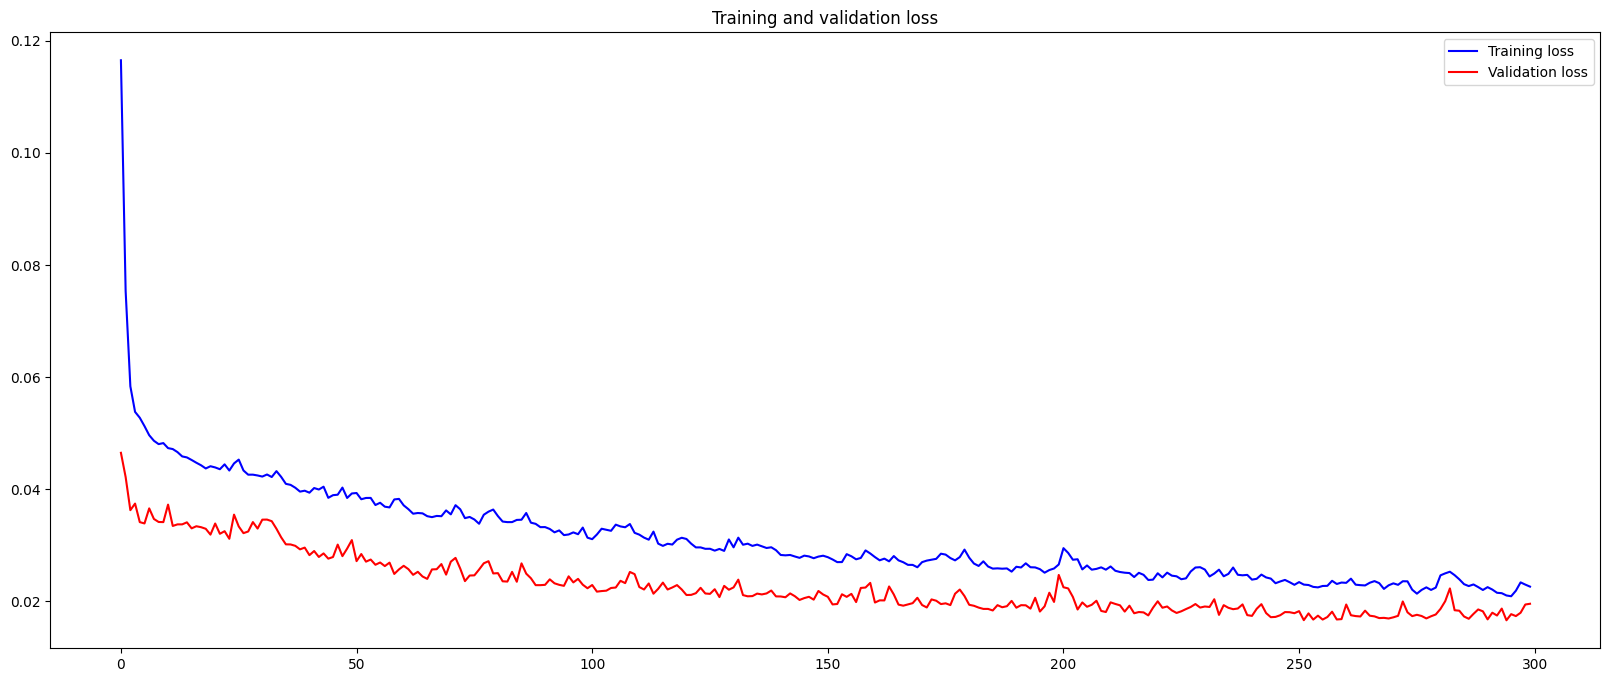

In [21]:
plot_loss(history_conv_lstm)

In [22]:
conv_lstm_model = tf.keras.models.load_model(
    "model_experiments/model_conv_lstm.keras")

model_preds = make_preds(conv_lstm_model, x_test_conv_lstm)
model_results = evaluate_preds(y_true=tf.squeeze(y_test),
                               y_pred=model_preds)

model_results

10/10 [==============================] - 2s 23ms/step


{'mae': 0.013113775, 'mse': 0.0003441261, 'r2': 0.8497911691665649}

#### Plot predictions

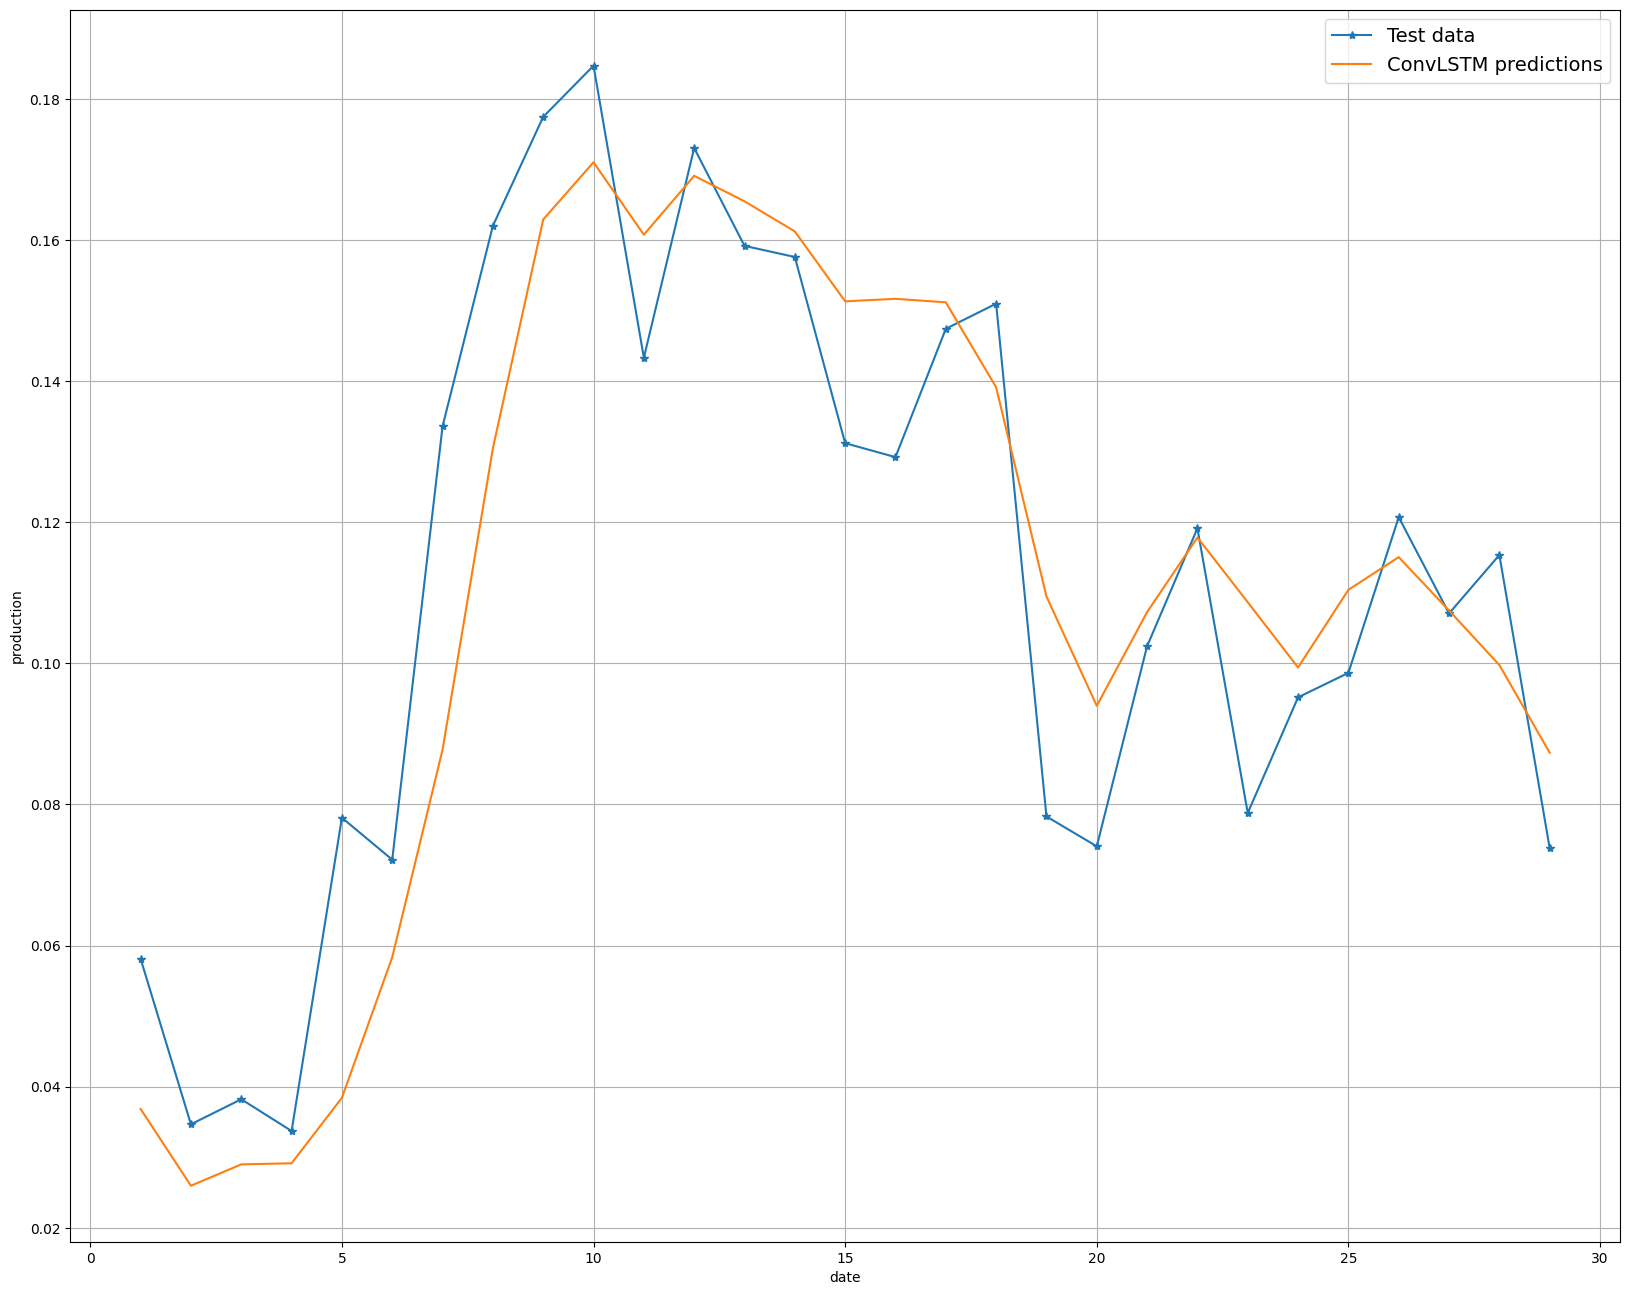

In [23]:
import numpy as np

start_offset = 1
end_offset = 30
plt.figure(figsize=(20, 16))


plot_time_series(
    timesteps=np.arange(x_test.shape[0]),
    values=y_test,
    start=start_offset,
    end=end_offset,
    format='-*',
    label="Test data"
)

plot_time_series(
    timesteps=np.arange(x_test.shape[0]),
    values=model_preds,
    start=start_offset,
    end=end_offset,
    format="-",
    label="ConvLSTM predictions"
)

In [26]:
import time
from deap import base, creator, tools
import random

# ========= Fonction modèle =========
def create_model(filters, kernel_size, activation, dense_units, learning_rate):
    model = tf.keras.Sequential([
        tf.keras.layers.ConvLSTM1D(filters=int(filters), kernel_size=(int(kernel_size),), activation=activation,
                                   return_sequences=True, input_shape=x_train_conv_lstm.shape[1:]),
        tf.keras.layers.ConvLSTM1D(filters=int(filters), kernel_size=(int(kernel_size),), activation=activation,
                                   return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=int(dense_units), activation='relu'),
        tf.keras.layers.Dense(1, activation="linear")
    ])
    model.compile(loss="mae", optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    return model

# ========= Fonction évaluation =========
def evaluate(individual):
    filters, kernel_size, activation, dense_units, learning_rate = individual
    model = create_model(filters, kernel_size, activation, dense_units, learning_rate)
    
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=1,
        restore_best_weights=True
    )
    
    history = model.fit(
        x_train_conv_lstm, y_train,
        epochs=2,
        batch_size=128,
        verbose=0,
        validation_data=(x_val_conv_lstm, y_val),
        callbacks=[early_stop]
    )
    
    mae = history.history['val_loss'][-1]
    return (mae,)

# ========= Mutation et croisement =========
def mut_mixed(ind, indpb=0.2):
    for i in range(len(ind)):
        if i == 1:
            continue
        if random.random() < indpb:
            if isinstance(ind[i], float):
                ind[i] += random.gauss(0, 0.001)
                ind[i] = max(0.0001, min(0.01, ind[i]))
            elif isinstance(ind[i], int):
                ind[i] += random.randint(-8, 8)
                ind[i] = max(1, min(256, ind[i]))
            elif isinstance(ind[i], str):
                ind[i] = 'relu' if ind[i] == 'tanh' else 'tanh'
    return ind,

def cx_mixed(ind1, ind2):
    for i in range(len(ind1)):
        if random.random() < 0.5:
            ind1[i], ind2[i] = ind2[i], ind1[i]
    return ind1, ind2

# ========= Configuration DEAP =========
if not hasattr(creator, "FitnessMin"):
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
if not hasattr(creator, "Individual"):
    creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("filters", random.choice, [32, 64, 128])
toolbox.register("kernel_size", random.choice, [1])
toolbox.register("activation", random.choice, ['relu', 'tanh'])
toolbox.register("dense_units", random.choice, [32, 64, 128])
toolbox.register("learning_rate", random.uniform, 0.0001, 0.008)

toolbox.register("individual", tools.initCycle, creator.Individual,
    (toolbox.filters, toolbox.kernel_size, toolbox.activation, toolbox.dense_units, toolbox.learning_rate), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", cx_mixed)
toolbox.register("mutate", mut_mixed, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# ========= Exécution GA avec meilleur global =========
start_ga_time = time.time()

n_generations = 4
population_size = 10

population = toolbox.population(n=population_size)
best_overall = None

for gen in range(n_generations):
    print(f"\n Génération {gen+1}")
    fitnesses = list(map(toolbox.evaluate, population))
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit

    # Suivi du meilleur global
    gen_best = tools.selBest(population, 1)[0]
    if best_overall is None or gen_best.fitness.values[0] < best_overall.fitness.values[0]:
        best_overall = creator.Individual(gen_best)
        best_overall.fitness.values = gen_best.fitness.values

    print(" Population :")
    for i, ind in enumerate(population):
        print(f"  ➤ Individu {i+1}: {ind} ➤ MAE = {ind.fitness.values[0]:.4f}")

    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))

    for c1, c2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < 0.5:
            toolbox.mate(c1, c2)
            del c1.fitness.values, c2.fitness.values

    for mutant in offspring:
        if random.random() < 0.2:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    invalids = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = list(map(toolbox.evaluate, invalids))
    for ind, fit in zip(invalids, fitnesses):
        ind.fitness.values = fit

    population[:] = offspring

end_ga_time = time.time()

# ========= Réentraînement final =========
print(f"\n Meilleurs hyperparamètres globaux trouvés : {best_overall}")
filters, kernel_size, activation, dense_units, learning_rate = best_overall
model = create_model(filters, kernel_size, activation, dense_units, learning_rate)

start_train_opt = time.time()
model.fit(x_train_conv_lstm, y_train, epochs=30, batch_size=512, verbose=0,
          validation_data=(x_val_conv_lstm, y_val))
training_time_opt = time.time() - start_train_opt

# ========= Évaluation finale =========
y_pred = model.predict(x_test_conv_lstm)
r2 = r2_score(y_test, y_pred)
mae_metric = tf.keras.metrics.MeanAbsoluteError()
mae_metric.update_state(y_test, y_pred)
mae = mae_metric.result().numpy()


# ========= Affichage final =========
print("\n Résumé des performances :")
print(f"  ➤ R² de base              : {model_results['r2']:.4f}")
print(f"  ➤ MAE de base             : {model_results['mae']:.4f}")
print(f"  ➤ Temps entraînement base : {training_duration_conv_lstm:.2f} s")
print(f"  ➤ R² optimisé             : {r2:.4f}")
print(f"  ➤ MAE optimisé            : {mae:.4f}")
print(f"  ➤ Temps entraînement opti : {training_time_opt:.2f} s")
print(f"  ➤ Temps GA total          : {end_ga_time - start_ga_time:.2f} s")
print(f"  ➤ Hyperparamètres choisis : {best_overall}")



 Génération 1
 Population :
  ➤ Individu 1: [128, 1, 'relu', 64, 0.007031899760215015] ➤ MAE = 0.0361
  ➤ Individu 2: [64, 1, 'tanh', 32, 0.005122099729062771] ➤ MAE = 0.0351
  ➤ Individu 3: [32, 1, 'relu', 32, 0.0019340719281294217] ➤ MAE = 0.0370
  ➤ Individu 4: [128, 1, 'relu', 128, 0.0002825333795725879] ➤ MAE = 0.0370
  ➤ Individu 5: [64, 1, 'tanh', 32, 0.007437848301051401] ➤ MAE = 0.0463
  ➤ Individu 6: [64, 1, 'relu', 32, 0.004220550053167713] ➤ MAE = 0.0349
  ➤ Individu 7: [64, 1, 'tanh', 128, 0.0015237628680239757] ➤ MAE = 0.0377
  ➤ Individu 8: [32, 1, 'relu', 32, 0.0015424092058048482] ➤ MAE = 0.0352
  ➤ Individu 9: [64, 1, 'relu', 32, 0.002057665729452746] ➤ MAE = 0.0378
  ➤ Individu 10: [32, 1, 'tanh', 64, 0.004737711131001344] ➤ MAE = 0.0352

 Génération 2
 Population :
  ➤ Individu 1: [32, 1, 'tanh', 64, 0.005587331665303947] ➤ MAE = 0.0374
  ➤ Individu 2: [34, 1, 'tanh', 71, 0.0055050159462361374] ➤ MAE = 0.0344
  ➤ Individu 3: [123, 1, 'tanh', 64, 0.00473771113100134